### Dataset and Variables

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape
#The data is from 90,189 players that installed the game while the AB-test was running.

(90189, 5)

### Descriptive Statistic 

In [6]:
df["userid"].unique()

array([    116,     337,     377, ..., 9999710, 9999768, 9999861])

In [5]:
df["userid"].nunique()

90189

In [7]:
df.groupby("version")[["userid"]].nunique()
#there are roughly the same number of players in each A/B group

,userid
version,
gate_30,44700
gate_40,45489


Plot the distribution of the number of game rounds players played during their first week playing the game.

In [12]:
# The distribution of game rounds
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby("sum_gamerounds")["userid"].count()

In [13]:
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

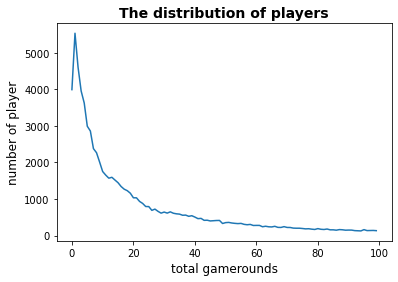

In [15]:
# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

In the plot above we can see that some players install the game but then never play it (0 game rounds).

In [16]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

In [17]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")
#we have a benchmark

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


In [18]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


### Bootstrapping 

- Creating 500 samples of dataset (bootstraping)
- Calculating 1-day & 7-days retentions for A/B groups
- Plotting the bootstrap distributions
- Calculating retention rate difference between the two A/B groups
- Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
- Evaluating results and making recommendation

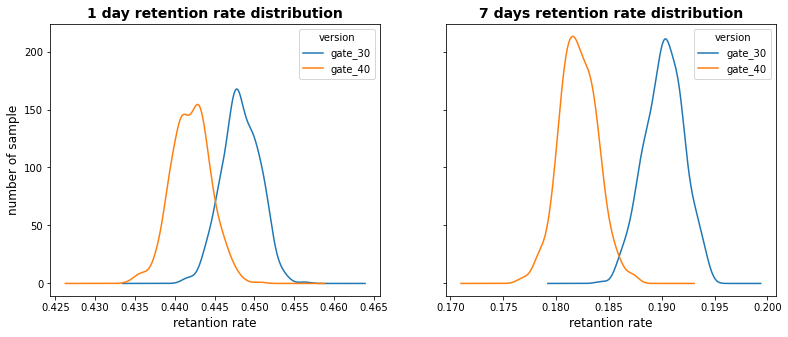

In [20]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

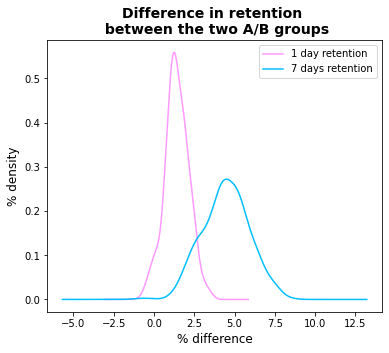

In [21]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

In [22]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 96.0%       
The probability that 7-days retention is greater when the gate is at level 30: 99.6% 


### Conclusion

If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics.